In [1]:
resolution = 0.0218

slicesa = 4400

slicesb = 4400

length = 160 

lengtha = resolution * slicesa

lengthb = resolution * slicesb

end_top = length - lengtha

print('overlapping region is: ', end_top, '-', lengtha)

slice1 = int(end_top / resolution)

slice2 = int((lengtha-end_top) / resolution)

print('overlapping slice volume1 from:', slice1, 'to', slicesa)
print('overlapping slice volume2 from:', 0, '-', slice2)

overlapping region is:  64.08 - 95.92
overlapping slice volume1 from: 2939 to 4400
overlapping slice volume2 from: 0 - 1460


In [2]:
#EL PROBLEMA AL CONCATENAR ES QUE NO TIENEN EL MIMSO TAMAÑO EN X E Y
4280 - 1144

3136

In [1]:

import os
import numpy as np
import tifffile
from tqdm import tqdm
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])

    tiff_sequence = tifffile.TiffSequence(tiff_files)
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)


c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from tqdm import tqdm
def write_sequence(folder_path, name, volume):
    """
    Save a 3D volume as a sequence of TIFF files in a folder.
    
    Args:
    folder_path (str): Path to the folder where TIFF files will be saved.
    name (str): Name of the TIFF files.
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    """

    folder_path = folder_path / name

    # Create the folder if it doesn't exist
    Path(folder_path).mkdir(parents=True, exist_ok=True)

    # Save each slice as a TIFF file with progress bar
    with tqdm(total=volume.shape[0], desc="Saving") as pbar:
        for i in range(volume.shape[0]):
            tifffile.imwrite(f"{folder_path}/{name}_{i:04d}.tif", volume[i])
            pbar.update(1)
    
    print("Saving complete.")


In [3]:
from pathlib import Path
folder1 = Path('C:/Users/alberto.vicente/Documents/temporal/volumenes/3/bot_eq')
folder2 = Path('C:/Users/alberto.vicente/Documents/temporal/volumenes/2/top')

bot = read_sequence(folder1)
#top = read_sequence(folder2)

Progress:  13%|█▎        | 582/4425 [00:10<01:06, 57.75it/s]


KeyboardInterrupt: 

In [53]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.measure import regionprops
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

def get_angle(volume,show = False, top_threshold = 65535, rotate90 = False):

    middle_slice = volume[len(volume)//2]

    if rotate90:

        middle_slice = np.rot90(middle_slice)

    top_index = np.where(middle_slice > top_threshold)

    threshold_value = threshold_otsu(middle_slice[middle_slice > 10000])

    print('threshold value is: ', threshold_value)

    thresholded_slice = middle_slice > threshold_value

    thresholded_slice[top_index] = 0

    # Label the objects in the thresholded slice
    labeled_slice = label(thresholded_slice)

    # Get the properties of each labeled region
    regions = regionprops(labeled_slice)

    # Find the largest connected component
    largest_component = max(regions, key=lambda region: region.area)

    # Create a mask to keep only the largest component
    mask = np.zeros_like(labeled_slice)
    mask[labeled_slice == largest_component.label] = 1

    # Apply the mask to the thresholded slice
    thresholded_slice = thresholded_slice * mask

    # Compute the rotation angle of the largest component
    rotation_angle = largest_component.orientation

    # Convert the angle from radians to degrees
    rotation_angle_degrees = np.degrees(rotation_angle)

    rotated_slice = rotate(thresholded_slice, -rotation_angle_degrees)

    plt.hist(middle_slice[middle_slice>10000].ravel(), bins=256)
    plt.title('Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.axvline(threshold_value, color='r', linestyle='dashed', linewidth=2)
    plt.show()

    if show:

        # Print the rotation angle
        print(f"The rotation angle of the largest component is {rotation_angle_degrees} degrees.")

        # Plotting the original middle slice
        plt.subplot(2, 2, 1)
        plt.imshow(middle_slice, cmap='gray')
        plt.title('Original Middle Slice')

        # Plotting the thresholded slice
        plt.subplot(2, 2, 2)
        plt.imshow(thresholded_slice, cmap='gray')
        plt.title('Thresholded Slice')

        # Plotting the largest component mask
        plt.subplot(2, 2, 3)
        plt.imshow(mask, cmap='gray')
        plt.title('Largest Component Mask')

        # Plotting the rotated slice
        plt.subplot(2, 2, 4)
        plt.imshow(rotated_slice, cmap='gray')
        plt.title('Rotated Slice')

        # Adjusting the layout and displaying the plot
        plt.tight_layout()
        plt.show()

    return -rotation_angle_degrees


In [54]:
from tqdm import tqdm

def rotate_volume(volume, angle):
    """
    Rotate a 3D volume by a given angle.
    
    Args:
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    angle (float): Angle in degrees.
    
    Returns:
    numpy.ndarray: A rotated 3D array.
    """

    rotated = rotate(volume[0], angle)

    shape = shape = (volume.shape[0],) + rotated.shape

    rotated_volume = np.zeros(shape=shape, dtype=volume.dtype)

    print(shape)

    
    # Rotate each slice of the volume with progress bar
    with tqdm(total=volume.shape[0], desc="Rotating") as pbar:
        for i in range(volume.shape[0]):
            rotated_volume[i] = rotate(volume[i], angle)
            pbar.update(1)
    
    return rotated_volume

In [55]:
from concurrent.futures import ThreadPoolExecutor

def rotate_slice(args):
    slice, angle = args
    return rotate(slice, angle)

def rotate_volume_concurrent(volume, angle):
    rotated = rotate(volume[0], angle)
    shape = (volume.shape[0],) + rotated.shape
    rotated_volume = np.zeros(shape=shape, dtype=volume.dtype)

    with ThreadPoolExecutor() as executor:
        args = [(volume[i], angle) for i in range(volume.shape[0])]
        for i, result in enumerate(tqdm(executor.map(rotate_slice, args), total=volume.shape[0], desc="Rotating")):
            rotated_volume[i] = result

    return rotated_volume

threshold value is:  31626


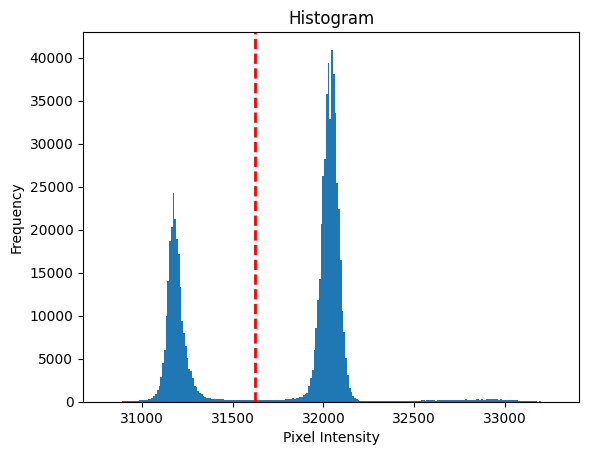

The rotation angle of the largest component is 1.7562362344497553 degrees.


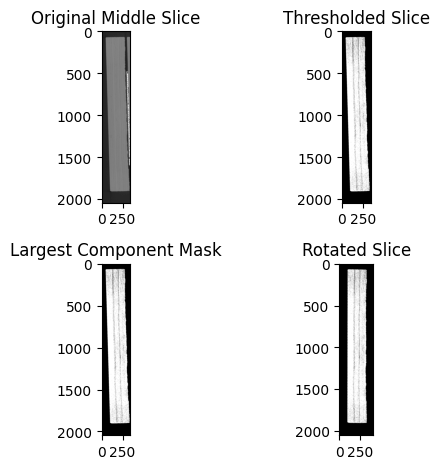

Rotating: 100%|██████████| 4425/4425 [00:22<00:00, 194.77it/s]


threshold value is:  31623


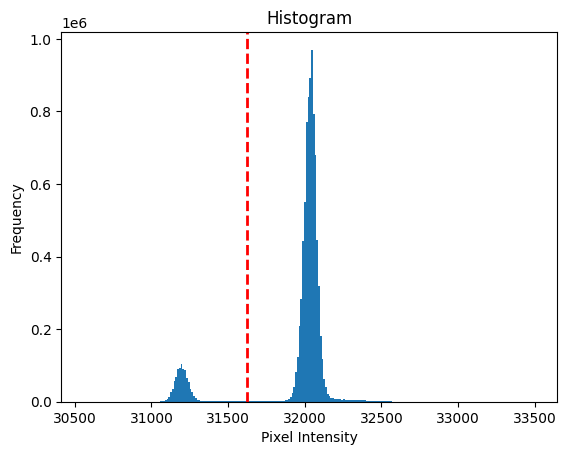

The rotation angle of the largest component is -0.7183978460000539 degrees.


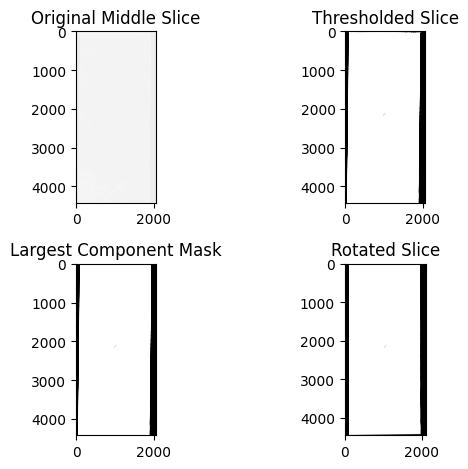

Rotating: 100%|██████████| 405/405 [00:32<00:00, 12.62it/s]


threshold value is:  31651


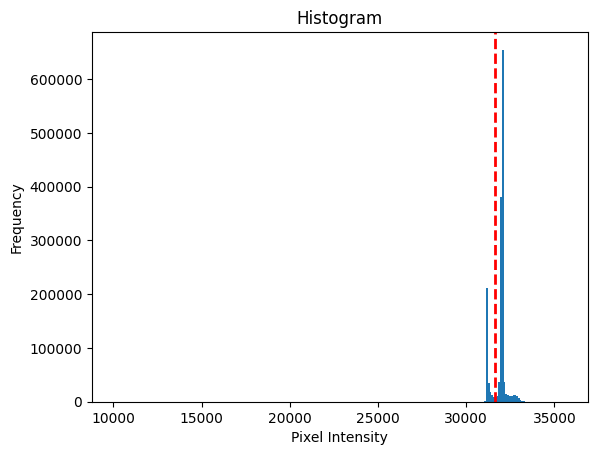

The rotation angle of the largest component is -0.3525804007986109 degrees.


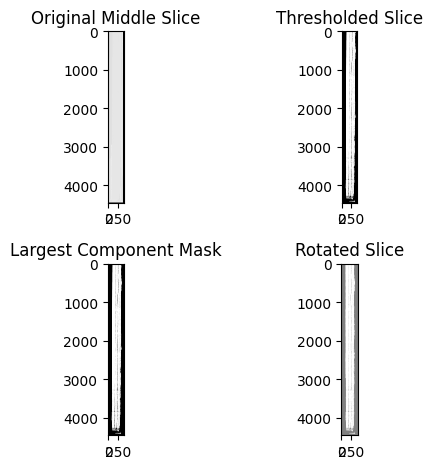

Rotating: 100%|██████████| 2111/2111 [00:30<00:00, 68.16it/s]


In [58]:
#main
angle = get_angle(bot,show = True,top_threshold = 32100)
rotated_bot = rotate_volume_concurrent(bot, angle)

resliced_bot = np.transpose(rotated_bot, (2, 0, 1))
angle = get_angle(resliced_bot,show = True)
rotated_bot = rotate_volume_concurrent(resliced_bot, angle)

resliced_bot = np.transpose(rotated_bot, (2, 0, 1))
angle = get_angle(resliced_bot,show = True,top_threshold = 32100, rotate90 = True)
rotated_bot = rotate_volume_concurrent(resliced_bot, angle)

final_bot = np.transpose(rotated_bot, (2, 0, 1))

In [59]:
output_folder = Path(r'C:\Users\alberto.vicente\Documents\temporal\volumenes\2\output')

write_sequence(output_folder, 'bot_rotated', final_bot)
#write_sequence(output_folder, 'top_8bit', top_eq)

Saving: 100%|██████████| 4452/4452 [02:50<00:00, 26.11it/s]

Saving complete.
